In [1]:
import os
# necessary as keras 3 has some issues with hublayers
os.environ["TF_USE_LEGACY_KERAS"] = "1"
import tensorflow as tf

2024-05-07 22:33:24.932904: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-07 22:33:25.651202: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Transfer learning with tensorflow part 1: feature extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are two main benefits:

1. Can leverage the existing neural network architecture proven to work on problems similar to our own
2. Can leverage a working neural architectures which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data

## Downloading and becoming one with the data

In [2]:
# Get data(10% of 10 food classes file)
import zipfile 
import os

# Unzip downloaded file
if not "10_food_classes_10_percent.zip" in os.listdir("./"):
    !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
    zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
    zip_ref.extractall()
    zip_ref.close()

In [3]:
# walk through 10% data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} in {dirpath}")

There are 2 directories and 0 in 10_food_classes_10_percent
There are 10 directories and 0 in 10_food_classes_10_percent/test
There are 0 directories and 250 in 10_food_classes_10_percent/test/fried_rice
There are 0 directories and 250 in 10_food_classes_10_percent/test/ice_cream
There are 0 directories and 250 in 10_food_classes_10_percent/test/ramen
There are 0 directories and 250 in 10_food_classes_10_percent/test/hamburger
There are 0 directories and 250 in 10_food_classes_10_percent/test/sushi
There are 0 directories and 250 in 10_food_classes_10_percent/test/chicken_curry
There are 0 directories and 250 in 10_food_classes_10_percent/test/grilled_salmon
There are 0 directories and 250 in 10_food_classes_10_percent/test/pizza
There are 0 directories and 250 in 10_food_classes_10_percent/test/steak
There are 0 directories and 250 in 10_food_classes_10_percent/test/chicken_wings
There are 10 directories and 0 in 10_food_classes_10_percent/train
There are 0 directories and 75 in 10_fo

## Creating data loaders(preparing the data)
We'll use the `ImageDataGenerator` class to load our images in batches

In [4]:
# Setup data inputs 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE=(224,224)
BATCH_SIZE=32
EPOCHS = 5

train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"
train_datagen=ImageDataGenerator(rescale=1/255.)
test_datagen=ImageDataGenerator(rescale=1/255.)

print("Training Images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Training Images:
Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


 ## Setting up callbacks(things to run whilst our model trains)
Callbacks are extra functionality you can add to your models to be performed during or after training.  Some of the most popular callbacks:

* Tracking experiments with the Tensorboard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training(before it takes too long and overfits) with Earlystopping Callbacks

In [5]:
#Create Tensorboard callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name,experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
    print(f"Saving TensorBoard log files to:{log_dir}")
    return tensorboard_callback

## Creating models using tensorflow hub

In the past we've used Tensorflow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from Tensorflow Hub.

We can access pretrained models from https://www.tensorflow.org/hub

In [6]:
# import dependencies
import tensorflow as tf 
import tensorflow_hub as hub
from tensorflow.keras import layers
import keras


In [7]:
# Let's make a create_model() function to create a model from a URL

def create_model(model_url,num_classes=10):
    """
    Takes a tensorflow hub URL and creates a keras sequential model with it

    Args:
        model_url (str): A tensorflow hub feature extraction URL
        num_classes (int): Number of output neurons in the output layer,
        should be equal to number of target classes, default 10.

    Returns:
        An uncompiled Keras Sequential model with model_url as feature extractor
        layer and Dense output layer with num_classes output neurons
    """

    # Download the pretrained model and save it as keras layer
    feature_extractor_layer = hub.KerasLayer(model_url,trainable=False,input_shape=IMAGE_SHAPE+(3,))
    model = tf.keras.Sequential([
        feature_extractor_layer,
        tf.keras.layers.Dense(num_classes,activation="softmax")
    ])
    return model

In [8]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"


### Creating ResNet Tensorflow Hub Feature Extraction Model

In [9]:
# Create resnet model
resnet_model = create_model(resnet_url,10)
resnet_model.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])
resnet_model.summary()


2024-05-07 22:33:26.917627: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-07 22:33:26.945186: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-07 22:33:26.945442: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              23564800  
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [10]:
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                 callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",experiment_name="resnet50V2")])

Saving TensorBoard log files to:tensorflow_hub/resnet50V2/20240507-223328
Epoch 1/5


2024-05-07 22:33:41.097944: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1715117621.614379  297672 service.cc:145] XLA service 0x7a036d5d9750 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1715117621.614409  297672 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 SUPER, Compute Capability 8.9
2024-05-07 22:33:41.619974: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1715117621.675193  297672 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


24/24 [==============================] - 19s 258ms/step - loss: 2.0790 - accuracy: 0.2960 - val_loss: 1.2235 - val_accuracy: 0.6216
Epoch 2/5
24/24 [==============================] - 5s 231ms/step - loss: 0.9177 - accuracy: 0.7320 - val_loss: 0.8801 - val_accuracy: 0.7192
Epoch 3/5
24/24 [==============================] - 5s 227ms/step - loss: 0.6310 - accuracy: 0.8213 - val_loss: 0.7795 - val_accuracy: 0.7540
Epoch 4/5
24/24 [==============================] - 5s 226ms/step - loss: 0.4947 - accuracy: 0.8653 - val_loss: 0.7091 - val_accuracy: 0.7804
Epoch 5/5
24/24 [==============================] - 5s 229ms/step - loss: 0.3975 - accuracy: 0.9013 - val_loss: 0.6834 - val_accuracy: 0.7840


In [11]:
# Let's create a function to plot our loss curves
from matplotlib import pyplot as plt
def plot_graphs(title,plot1,plot2,label1,label2,xlabel,ylabel):
    plt.title(title)
    plt.plot(plot1,label=label1)
    plt.plot(plot2,label=label2)
    plt.xticks([1,2,3,4])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

Wow!

That. Is. Incredible. Our transfer learning feature extracting model out performed ALL of the previous models we built by hand... (substantially) and in a quicker training time AND with only 10% of the training examples.

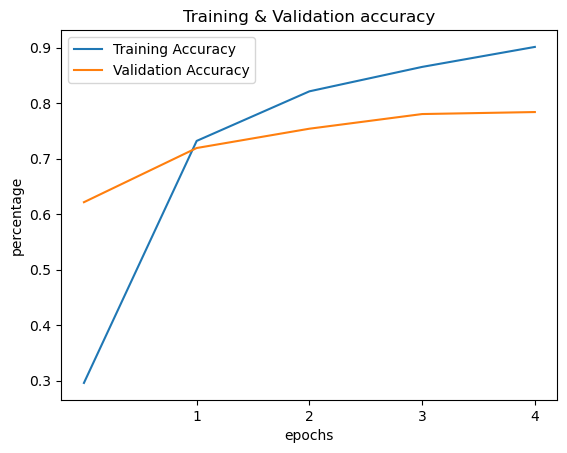

In [12]:
plot_graphs(title="Training & Validation accuracy",
plot1=resnet_history.history["accuracy"],
plot2=resnet_history.history["val_accuracy"],
label1="Training Accuracy",
label2="Validation Accuracy",
xlabel="epochs",
ylabel="percentage")

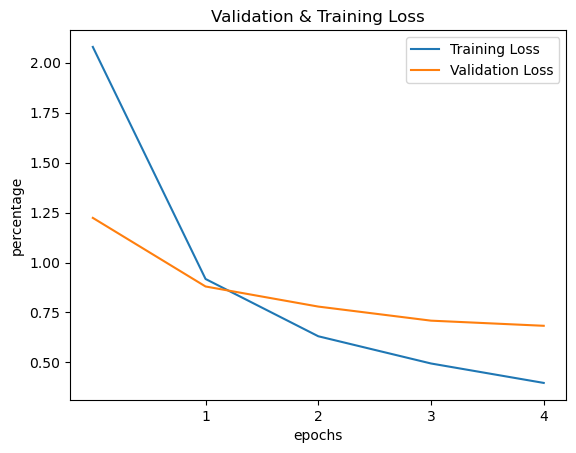

In [13]:
plot_graphs(title="Validation & Training Loss",
plot1=resnet_history.history["loss"],
plot2=resnet_history.history["val_loss"],
label1="Training Loss",
label2="Validation Loss",
xlabel="epochs",
ylabel="percentage")


### Creating and testing EfficientNetB0 Tensorflow Hub model

In [14]:
# Create resnet model
efficientnet_model = create_model(efficientnet_url,10)
efficientnet_model.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])
efficientnet_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              4049564   
                                                                 
 dense_1 (Dense)             (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [15]:
# details on efficient net - https://paperswithcode.com/method/efficientnet#:~:text=EfficientNet%20is%20a%20convolutional%20neural,resolution%20using%20a%20compound%20coefficient
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                  epochs=10,steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                 callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",experiment_name="efficientnetB0")])

Saving TensorBoard log files to:tensorflow_hub/efficientnetB0/20240507-223414
Epoch 1/10
24/24 [==============================] - 12s 265ms/step - loss: 1.7882 - accuracy: 0.4667 - val_loss: 1.2384 - val_accuracy: 0.7380
Epoch 2/10
24/24 [==============================] - 5s 229ms/step - loss: 1.0344 - accuracy: 0.7667 - val_loss: 0.8348 - val_accuracy: 0.8192
Epoch 3/10
24/24 [==============================] - 5s 220ms/step - loss: 0.7407 - accuracy: 0.8293 - val_loss: 0.6793 - val_accuracy: 0.8436
Epoch 4/10
24/24 [==============================] - 5s 223ms/step - loss: 0.5964 - accuracy: 0.8680 - val_loss: 0.5977 - val_accuracy: 0.8540
Epoch 5/10
24/24 [==============================] - 5s 222ms/step - loss: 0.5055 - accuracy: 0.8827 - val_loss: 0.5503 - val_accuracy: 0.8640
Epoch 6/10
24/24 [==============================] - 5s 234ms/step - loss: 0.4389 - accuracy: 0.9000 - val_loss: 0.5137 - val_accuracy: 0.8664
Epoch 7/10
24/24 [==============================] - 5s 229ms/step - l

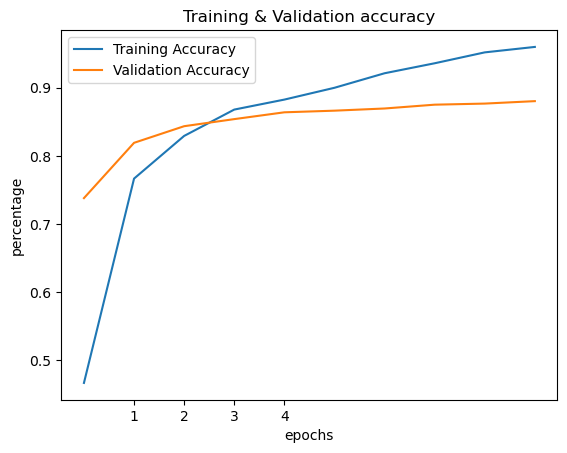

In [16]:
plot_graphs(title="Training & Validation accuracy",
plot1=efficientnet_history.history["accuracy"],
plot2=efficientnet_history.history["val_accuracy"],
label1="Training Accuracy",
label2="Validation Accuracy",
xlabel="epochs",
ylabel="percentage")

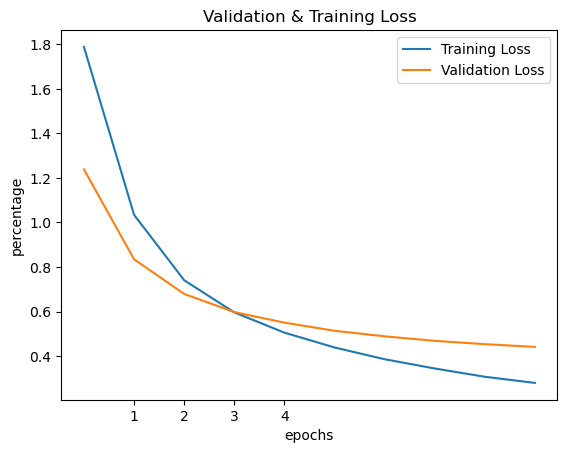

In [17]:
plot_graphs(title="Validation & Training Loss",
plot1=efficientnet_history.history["loss"],
plot2=efficientnet_history.history["val_loss"],
label1="Training Loss",
label2="Validation Loss",
xlabel="epochs",
ylabel="percentage")


In [18]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              4049564   
                                                                 
 dense_1 (Dense)             (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [19]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              23564800  
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [20]:
# How many layers does our efficientnetb0 feature extractor have?
len(efficientnet_model.layers[0].weights)

309

## Different types of transfer learning

 * **"As is"** transfer learning - using existing model with no changes whatsoever(e.g using imagenet model on 1k imagenet classes)
 * **"Feature extraction"** transfer learning - using pretrained patterns of existing models(e.g efficient net b0 trained on imagenet) and adjust the output layer for your own purposes(e.g above using 1000 classes -> 10 classes of food)
 * **"Fine-tuning"** transfer learning - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers(including new output layers)

## Comparing our model results using Tensorboard

**Note:** When you upload things to Tensorboard.dev, your experiments are public.

**No longer applies with latest tensorboard it's hosted locally**

In [ ]:
# Upload Tensorboard dev records
!tensorboard --logdir ./tensorflow_hub/ 

2024-05-07 22:39:48.072686: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-07 22:39:48.714473: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-05-07 22:39:49.510060: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-07 22:39:49.536237: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. 

In [ ]:
# Checkout what tensorboard experiments you have - deprecated
# !tensorboard dev list

In [ ]:
# delete experiment -deprecated
# !tensorboard dev delete --experiment_id 